# 1. Clustering

Sex

    Values 1: Male 2: Female

Age

**How have you been feeling over the last two weeks**

q1 - I have felt cheerful and in good spirits

q2 - I have felt calm and relaxed 

q3 - I have felt active and vigorous 

q4 - I woke up feeling fresh and rested

q5 - My daily life has been filled with things that interest me

Values:
1. All of the time.
2. Most of the time
3. More than half of the time
4. Less than half of the time
5. Some of the time
6. At no time

**Please tell me how often you feel this way**

w1 - At my work I feel full of energy 

w2 - I am enthusiastic about my job 

w3 - Time flies when I am working 

w4 - In my opinion, I am good at my job 

Values for variables Q90a to Q90f

1. Always.
2. Most of the time
3. Sometimes
4. Rarely
5. Never


## PCA, Elbow method Clustering, K-means clustering

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

init_df = pd.read_csv('EWCS_2016.csv')
init_df = init_df.replace(-999, np.nan)
init_df = init_df.dropna()
init_df.columns = ["sex", "age", "q1", "q2", "q3", "q4", "q5", "w1", "w2", "w3", "w4"]
init_df.head()

,sex,age,q1,q2,q3,q4,q5,w1,w2,w3,w4
0,1.0,63.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0
1,2.0,58.0,2.0,3.0,2.0,3.0,2.0,2.0,3.0,2.0,2.0
2,2.0,32.0,2.0,2.0,3.0,2.0,3.0,2.0,2.0,2.0,2.0
3,1.0,35.0,3.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0
4,2.0,27.0,2.0,2.0,3.0,3.0,2.0,2.0,4.0,2.0,2.0


## PCA

In [554]:
from sklearn.decomposition import PCA
from sklearn import preprocessing


df = init_df.copy(deep=True)

def do_pca(init_df, delta=None, devide=True,
           return_scree=True, return_info=True):
    
    """
    A cluster cannot be smaller than
    5% of the data. 
    
    Samples are grouped in clusters if 
    length between them is less than 
    the sum of 10% of each dimention.
    """
    
    # Scaling
    df = init_df.copy(deep=True)
    df = preprocessing.scale(df)
    
    # Model
    pca = PCA()
    pca.fit(df)
    pca_data = pca.transform(df)
    
    per_var = np.round(pca.explained_variance_ratio_ * 100, 1)
    
    labels = ['PC' + str(i) for i in range(1, len(per_var) + 1)]

    # Plots
    # Scree plot
    if return_scree:
        plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
        plt.ylabel('Percentage of Explained Variance')
        plt.xlabel('Principal Component')
        plt.title('Scree Plot')
        plt.show()

        
    # PC1 vs PC2
    pca_df = pd.DataFrame(pca_data, index=init_df.index, columns=labels)
    
    plt.scatter(pca_df.PC1, pca_df.PC2) 
    plt.title('PCA Graph')
    plt.xlabel(f'PC1 - {per_var[0]}')
    plt.ylabel(f'PC2 - {per_var[1]}')
    
    if devide:
        seen = set()
        clusters = {}
        if not delta:
            d1 = (pca_df.PC1.max() - pca_df.PC1.min()) / 10
            d2 = (pca_df.PC2.max() - pca_df.PC2.min()) / 10
            delta = (d1 + d2) / 2
        
        for sample in pca_df.index:
            x, y = pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]

            found = False
            for s in seen:
                x1, y1 = pca_df.PC1.loc[s], pca_df.PC2.loc[s]
                if sum(np.power(np.array(x1, y1) - np.array((x, y)), 2)) < delta**2:
                    found = True
                    break

            if found:
                clusters[s].append(sample)
            else:
                clusters[sample] = [sample]
                seen.add(sample)

        clusts = {}
        for c in clusters:
            l = len(clusters[c])
            if l > len(df)/20:
                clusts[c] = clusters[c]
                x, y = pca_df.PC1.loc[c], pca_df.PC2.loc[c]
                plt.annotate(f'#{c}, sz={l}', (x, y))
    
        if return_info:
            print(f'Centers of clusters are represented by the foolowing samples: \n', *list(clusts.keys()))
            return clusts

    plt.show()
    return None

### Raw Data

In [555]:
df = init_df.copy(deep=True)
df.head()

,sex,age,q1,q2,q3,q4,q5,w1,w2,w3,w4
0,1.0,63.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0
1,2.0,58.0,2.0,3.0,2.0,3.0,2.0,2.0,3.0,2.0,2.0
2,2.0,32.0,2.0,2.0,3.0,2.0,3.0,2.0,2.0,2.0,2.0
3,1.0,35.0,3.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0
4,2.0,27.0,2.0,2.0,3.0,3.0,2.0,2.0,4.0,2.0,2.0


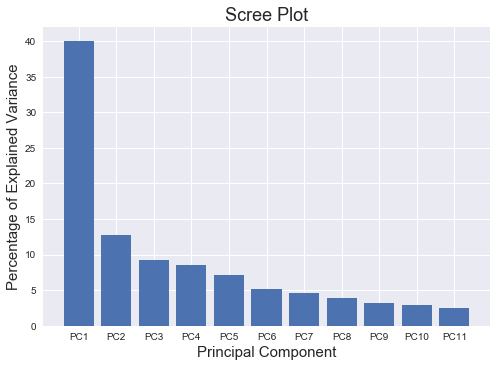

Centers of clusters are represented by the foolowing samples: 
 0


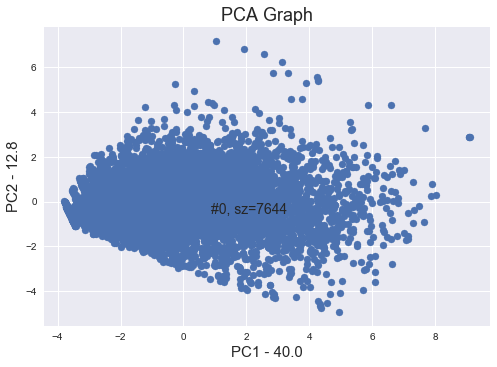

In [556]:
clusts = do_pca(df, delta=8)

### Data-frame v.2

1. For q:

    1, 2, 3 = 1

    4, 5, 6 = 2

2. For w:

    1, 2, 3, 4 = 1

    5, 6 = 2

In [210]:
df = init_df.copy(deep=True)

# q
for c in range(2, 7):
    for r in range(len(df)):
        if df.iloc[r, c] < 4:
            df.iloc[r, c] = 1
        else:
            df.iloc[r, c] = 2
            
# w
for c in range(7, 11):
    for r in range(len(df)):
        if df.iloc[r, c] < 5:
            df.iloc[r, c] = 1
        else:
            df.iloc[r, c] = 2
            
df2 = df.copy(deep=True)

df.head()

,sex,age,q1,q2,q3,q4,q5,w1,w2,w3,w4
0,1.0,63.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2.0,58.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2.0,32.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,35.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,2.0,27.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


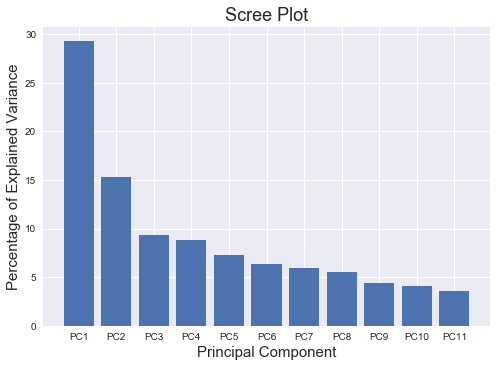

Centers of clusters are represented by the foolowing samples: 
 0


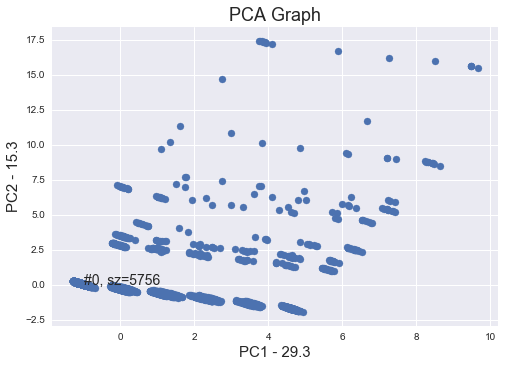

In [208]:
clusts = do_pca(df2)

### Data-frame v.3

Modified DF v.2

1. Join q1 and q4

2. Join q3 and q5

3. Join w1 and w2

In [211]:
df['q14'] = (df.q1 + df.q4) / 2
df['q35'] = (df.q3 + df.q5) / 2
df['w12'] = (df.w1 + df.w2) / 2

df.drop(['q1', 'q3', 'q4', 'q5', 'w1', 'w2'], axis=1, inplace=True)

df3 = df.copy(deep=True)

In [212]:
df.head()

,sex,age,q2,w3,w4,q14,q35,w12
0,1.0,63.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2.0,58.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2.0,32.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,35.0,1.0,1.0,1.0,1.0,1.0,1.0
4,2.0,27.0,1.0,1.0,1.0,1.0,1.0,1.0


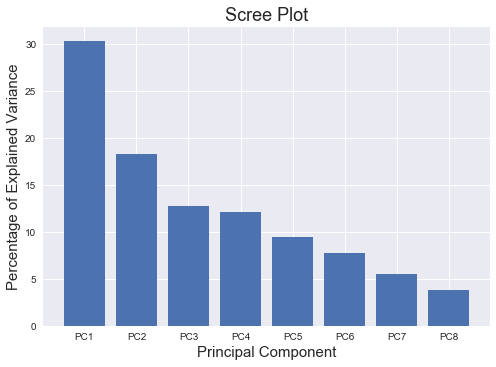

Centers of clusters are represented by the foolowing samples: 
 0


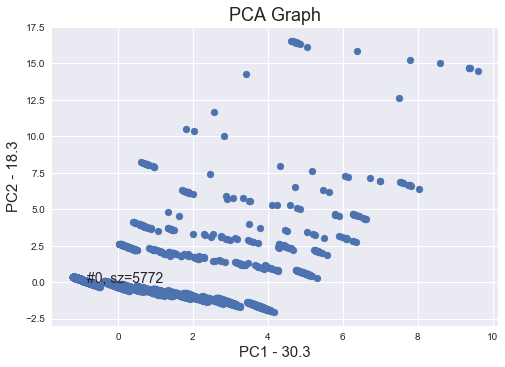

In [213]:
clusts = do_pca(df)

## K-means Clustering

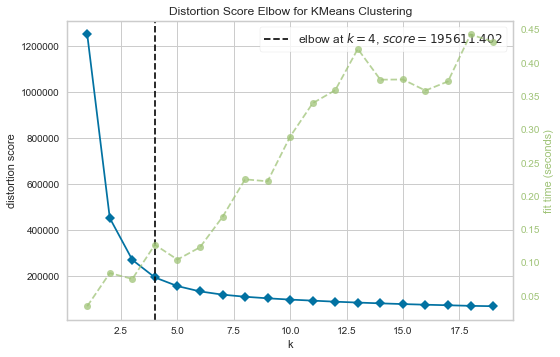

In [563]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))

visualizer.fit(df)
visualizer.show() 

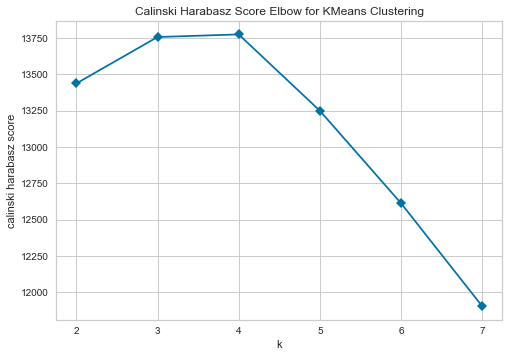

In [574]:
visualizer = KElbowVisualizer(
    model, k=(2,8), metric='calinski_harabasz', timings=False, locate_elbow=False
)

visualizer.fit(df)
visualizer.show() 

Text(0.5, 1.0, 'Elbow Method')

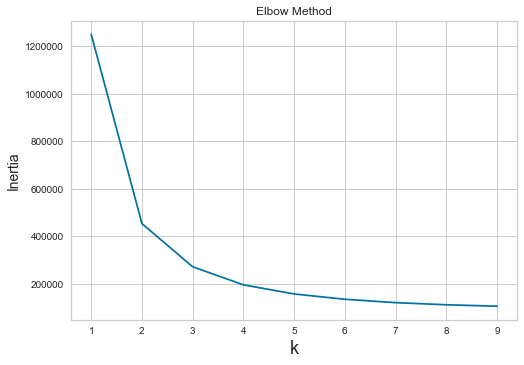

In [570]:
iner = []

for k in range(1, 10, 1):
    km = KMeans(n_clusters=k).fit(df)
    iner.append(km.inertia_)

plt.plot(range(1, 10), inertias)
plt.xlabel('k', fontsize=18)
plt.ylabel('Inertia', fontsize=14)
plt.title('Elbow Method')

In [557]:


def show_clusts(init_df):
    df = init_df.copy(deep=True)
    df = preprocessing.scale(df)

    pca = PCA()
    pca.fit(df)
    pca_data = pca.transform(df)
    per_var = np.round(pca.explained_variance_ratio_ * 100, 1)
    labels = ['PC' + str(i) for i in range(1, len(per_var) + 1)]
    
    pca_df = pd.DataFrame(pca_data, index=init_df.index, columns=labels)

    cols = ['black', 'firebrick', 'orange', 'lightgreen',
            'mediumturquoise', 'dodgerblue', 'stateblue', 'violet']

    for n in range(2, 5):
        km = KMeans(n_clusters=n, n_init=10, random_state=0).fit(df)
        pca_df['class'] = km.labels_

        for cl in np.unique(km.labels_):
            plt.scatter(pca_df[pca_df['class'] == cl].PC1,
                        pca_df[pca_df['class'] == cl].PC2,
                        c=cols[cl], label=f'Class {cl+1}')

        plt.title(f'{n} Clusters')
        plt.legend()
        plt.show()

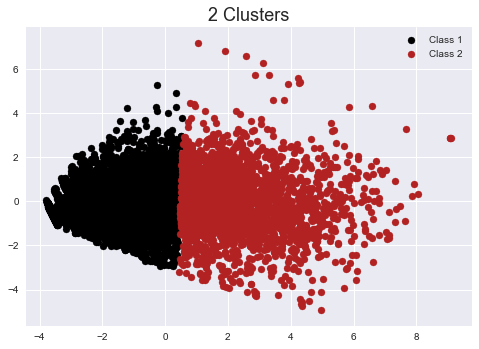

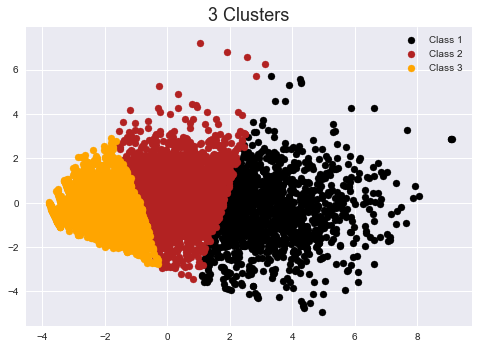

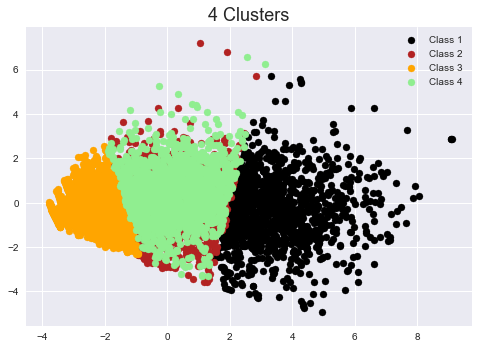

In [558]:
show_clusts(init_df)

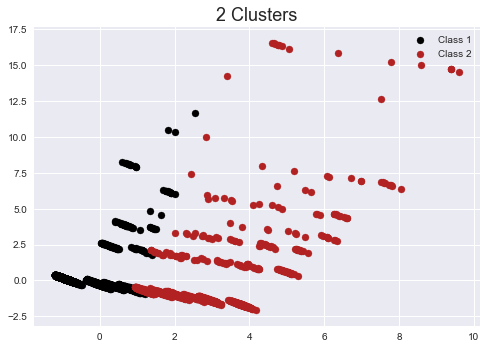

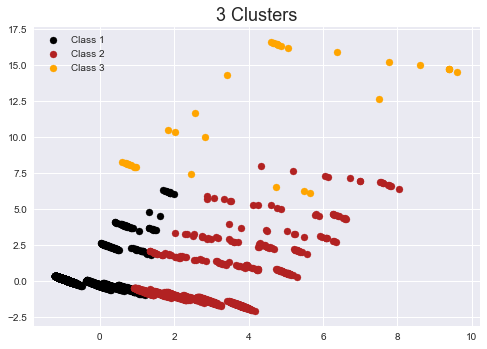

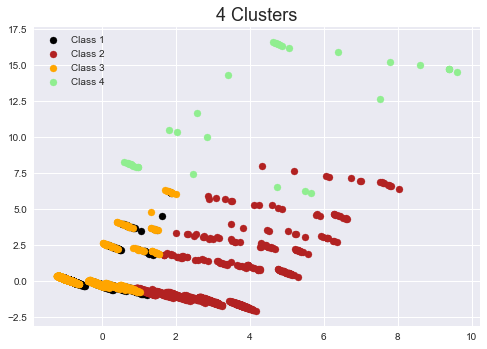

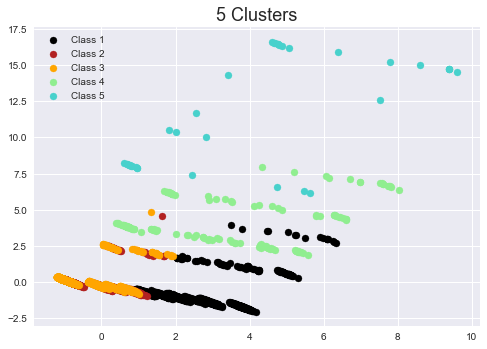

In [216]:
show_clusts(df3)

# 2. Regression

## Attributes for both student-mat.csv (Math course) and student-por.csv (Portuguese language course) datasets: 

1 school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira) 

2 sex - student's sex (binary: 'F' - female or 'M' - male) 

3 age - student's age (numeric: from 15 to 22) 

4 address - student's home address type (binary: 'U' - urban or 'R' - rural) 

5 famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3) 

6 Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart) 

7 Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 - 5th to 9th grade, 3 -“ secondary education or 4 - higher education) 

8 Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education) 

9 Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other') 

10 Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other') 

11 reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other') 

12 guardian - student's guardian (nominal: 'mother', 'father' or 'other') 

13 traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour) 

14 studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours) 

15 failures - number of past class failures (numeric: n if 1<=n<3, else 4) 

16 schoolsup - extra educational support (binary: yes or no) 

17 famsup - family educational support (binary: yes or no) 

18 paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no) 

19 activities - extra-curricular activities (binary: yes or no) 

20 nursery - attended nursery school (binary: yes or no) 

21 higher - wants to take higher education (binary: yes or no) 

22 internet - Internet access at home (binary: yes or no) 

23 romantic - with a romantic relationship (binary: yes or no) 

24 famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent) 

25 freetime - free time after school (numeric: from 1 - very low to 5 - very high) 

26 goout - going out with friends (numeric: from 1 - very low to 5 - very high) 

27 Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high) 

28 Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high) 

29 health - current health status (numeric: from 1 - very bad to 5 - very good) 

30 absences - number of school absences (numeric: from 0 to 93) 

### these grades are related with the course subject, Math or Portuguese: 

31 G1 - first period grade (numeric: from 0 to 20) 

31 G2 - second period grade (numeric: from 0 to 20) 

32 G3 - final grade (numeric: from 0 to 20, output target)


## Preprocessing

In [651]:
def prep(df, dummy=True):
    df.dropna(inplace=True)
    
    # Binary to 0/1
    df['school'] = np.where(df['school'] == 'GP', 0, 1)
    df['sex'] = np.where(df['sex'] == 'F', 0, 1)
    df['address'] = np.where(df['address'] == 'U', 1, 0)
    df['famsize'] = np.where(df['famsize'] == 'LE3', 0, 1)
    df['Pstatus'] = np.where(df['Pstatus'] == 'T', 1, 0)

    # Binary with yes/no to 0/1
    features = ['schoolsup', 'famsup', 'paid', 'activities',
                'nursery', 'higher', 'internet', 'romantic']
    for f in features:
        df[f] = np.where(df[f] == 'yes', 1, 0)
    
    if dummy:
        # Dummy vars for nominal features
        features = ['Mjob', 'Fjob', 'reason', 'guardian']
        mf = pd.get_dummies(df[features])
        df.drop(features, axis=1, inplace=True)
        df = df.join(mf)
    
    return df

In [652]:
init_df_mat = pd.read_csv('student-mat.csv', sep=';')
init_df_por = pd.read_csv('student-por.csv', sep=';')

In [683]:
# Read and preprocess data1
df_mat = pd.read_csv('student-mat.csv', sep=';')
df_mat = prep(df_mat, dummy=True)

# Read and preprocess data2
df_por = pd.read_csv('student-por.csv', sep=';')
df_por = prep(df_por, dummy=True)

df_mat.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,0,0,18,1,1,0,4,4,2,2,...,0,0,1,1,0,0,0,0,1,0
1,0,0,17,1,1,1,1,1,1,2,...,1,0,0,1,0,0,0,1,0,0
2,0,0,15,1,0,1,1,1,1,2,...,1,0,0,0,0,1,0,0,1,0
3,0,0,15,1,1,1,4,2,1,3,...,0,1,0,0,1,0,0,0,1,0
4,0,0,16,1,1,1,3,3,1,2,...,1,0,0,0,1,0,0,1,0,0


In [684]:
df_por.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,0,0,18,1,1,0,4,4,2,2,...,0,0,1,1,0,0,0,0,1,0
1,0,0,17,1,1,1,1,1,1,2,...,1,0,0,1,0,0,0,1,0,0
2,0,0,15,1,0,1,1,1,1,2,...,1,0,0,0,0,1,0,0,1,0
3,0,0,15,1,1,1,4,2,1,3,...,0,1,0,0,1,0,0,0,1,0
4,0,0,16,1,1,1,3,3,1,2,...,1,0,0,0,1,0,0,1,0,0


## Models

### OLS

In [685]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

In [686]:
df = df_por.copy(deep=True)
# df['const'] = np.ones(len(df))
df.corr().style.background_gradient(cmap='coolwarm').format('{0:,.1f}')

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
school,1.0,-0.1,0.1,-0.4,-0.0,0.0,-0.3,-0.2,0.3,-0.1,0.1,-0.1,-0.1,-0.0,-0.1,0.0,-0.1,-0.2,0.1,-0.0,0.0,0.0,0.0,0.0,-0.1,-0.2,-0.3,-0.3,-0.3,0.2,-0.1,0.0,-0.1,-0.1,0.1,-0.1,-0.1,0.1,-0.1,0.1,-0.1,0.2,-0.2,0.1,-0.1,-0.0
sex,-0.1,1.0,-0.0,0.0,-0.1,0.1,0.1,0.1,0.0,-0.2,0.1,-0.1,-0.1,0.1,0.1,-0.0,-0.1,0.1,-0.1,0.1,0.1,0.1,0.3,0.3,0.1,0.0,-0.1,-0.1,-0.1,-0.1,0.0,-0.0,0.1,0.1,-0.1,-0.0,-0.0,0.0,0.0,-0.0,0.1,0.0,-0.0,0.0,-0.0,-0.0
age,0.1,-0.0,1.0,-0.0,0.0,-0.0,-0.1,-0.1,0.0,-0.0,0.3,-0.2,-0.1,-0.0,-0.1,-0.0,-0.3,0.0,0.2,-0.0,-0.0,0.1,0.1,0.1,-0.0,0.1,-0.2,-0.1,-0.1,0.1,-0.1,0.0,-0.0,-0.0,0.1,-0.1,0.1,-0.0,-0.1,0.0,-0.0,-0.0,-0.0,-0.1,-0.0,0.3
address,-0.4,0.0,-0.0,1.0,-0.0,-0.1,0.2,0.1,-0.3,0.1,-0.1,0.0,0.0,-0.0,-0.0,0.0,0.1,0.2,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.1,0.2,0.2,0.2,-0.2,0.1,-0.0,0.1,0.1,0.0,0.1,-0.1,0.0,0.0,-0.1,0.2,-0.1,-0.0,0.0,0.0,-0.0
famsize,-0.0,-0.1,0.0,-0.0,1.0,0.2,0.0,0.0,-0.0,0.0,0.1,0.1,0.0,0.1,0.0,-0.1,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.1,-0.1,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.1,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.1,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0
Pstatus,0.0,0.1,-0.0,-0.1,0.2,1.0,-0.1,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.1,-0.0,0.0,0.1,-0.1,0.1,0.0,0.0,0.0,0.1,0.0,-0.1,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.1,0.1,-0.0,0.0,-0.0,0.0,-0.0,0.1,-0.1,-0.1
Medu,-0.3,0.1,-0.1,0.2,0.0,-0.1,1.0,0.6,-0.3,0.1,-0.2,-0.0,0.1,0.1,0.1,0.1,0.2,0.3,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.3,0.3,0.2,-0.4,0.3,-0.2,0.1,0.4,-0.1,0.2,-0.1,-0.0,0.3,-0.1,0.0,-0.0,0.1,-0.0,0.1,-0.1
Fedu,-0.2,0.1,-0.1,0.1,0.0,-0.0,0.6,1.0,-0.2,0.1,-0.2,0.0,0.1,0.1,0.1,0.1,0.2,0.2,-0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.2,-0.2,0.1,-0.2,0.1,0.3,-0.1,0.2,-0.2,0.0,0.3,-0.1,0.0,-0.0,0.1,0.1,-0.0,-0.1
traveltime,0.3,0.0,0.0,-0.3,-0.0,0.0,-0.3,-0.2,1.0,-0.1,0.1,-0.0,-0.0,-0.0,-0.0,-0.0,-0.1,-0.2,0.0,-0.0,0.0,0.1,0.1,0.1,-0.0,-0.0,-0.2,-0.2,-0.1,0.2,-0.1,0.0,-0.1,-0.1,-0.0,-0.1,0.1,-0.0,-0.0,0.1,-0.1,0.1,-0.1,0.0,-0.1,0.1
studytime,-0.1,-0.2,-0.0,0.1,0.0,-0.0,0.1,0.1,-0.1,1.0,-0.1,0.1,0.1,-0.0,0.1,0.0,0.2,0.0,0.0,-0.0,-0.1,-0.1,-0.1,-0.2,-0.1,-0.1,0.3,0.2,0.2,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.1,-0.0,0.0,-0.0,-0.1,-0.0,-0.1,0.2,0.0,-0.0,0.0


In [687]:
# all columns except from G3
pred_cols_all = [i for i in df.columns if i != 'G3']

# all columns except from G1, G2, G3
pred_cols = [i for i in df.columns if i not in ['G1', 'G2', 'G3']]

# y/X
y = df['G3']
X = df[pred_cols]
X_all = df[pred_cols_all]

# train/test split
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1)

x_train_all, x_test_all, y_train_all, y_test_all = train_test_split(
    X_all, y, test_size=0.25, random_state=1)

#### Model without G1 and G2

In [688]:
mod = sm.OLS(y_train, x_train).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     7.686
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           1.95e-30
Time:                        19:46:39   Log-Likelihood:                -1121.8
No. Observations:                 486   AIC:                             2324.
Df Residuals:                     446   BIC:                             2491.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
school               -1.1764      0.304     -3.867      0.000      -1.774      -0.579
sex                  -0.5898      0.284     -2.081      0.038      -1.147      -0.033
age                   0.1281      0.117      1.093      0.275      -0.102       0.359
address               0.3605      0.302      1.195      0.233      -0.232       0.953
famsize              -0.4531      0.275     -1.650      0.100      -0.993       0.087
Pstatus               0.1327      0.379      0.350      0.726      -0.612       0.878
Medu                 -0.1052      0.169     -0.622      0.534      -0.438       0.227
Fedu                  0.2499      0.155      1.612      0.108      -0.055       0.555
traveltime            0.1808      0.182      0.993      0.321      -0.177       0.539
studytime             0.3780      0.154      2.462      0.014       0.076       0.680
failures             -1.3380      0.216     -6.193      0.000      -1.763      -0.913
schoolsup            -1.3227      0.395     -3.352      0.001      -2.098      -0.547
famsup                0.0912      0.255      0.357      0.721      -0.410       0.593
paid                 -0.6197      0.521     -1.188      0.235      -1.645       0.405
activities            0.4781      0.248      1.928      0.055      -0.009       0.966
nursery               0.0308      0.302      0.102      0.919      -0.563       0.625
higher                1.8337      0.414      4.427      0.000       1.020       2.648
internet              0.5399      0.306      1.766      0.078      -0.061       1.141
romantic             -0.4005      0.256     -1.564      0.118      -0.904       0.103
famrel                0.2394      0.131      1.830      0.068      -0.018       0.496
freetime             -0.1631      0.124     -1.312      0.190      -0.407       0.081
goout                -0.0926      0.120     -0.771      0.441      -0.329       0.144
Dalc                 -0.0588      0.165     -0.356      0.722      -0.383       0.265
Walc                 -0.1649      0.131     -1.256      0.210      -0.423       0.093
health               -0.1549      0.086     -1.809      0.071      -0.323       0.013
absences             -0.0301      0.027     -1.101      0.272      -0.084       0.024
Mjob_at_home          1.4322      0.551      2.600      0.010       0.350       2.515
Mjob_health           1.9948      0.599      3.329      0.001       0.817       3.172
Mjob_other            1.5642      0.507      3.087      0.002       0.569       2.560
Mjob_services         1.6755      0.546      3.066      0.002       0.602       2.749
Mjob_teacher          1.9190      0.611      3.143      0.002       0.719       3.119
Fjob_at_home          2.0185      0.642      3.145      0.002       0.757       3.280
Fjob_health           1.3289      0.686      1.937      0.053      -0.020

In [689]:
y_pred = mod.predict(x_test)
print(f'MSE: {mse(y_pred, y_test)}')

MSE: 9.529890246086358


#### Model with G1 and G2

In [690]:
mod_all = sm.OLS(y_train_all, x_train_all).fit()
mod_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     65.72
Date:                Thu, 01 Apr 2021   Prob (F-statistic):          3.67e-162
Time:                        19:46:55   Log-Likelihood:                -771.46
No. Observations:                 486   AIC:                             1627.
Df Residuals:                     444   BIC:                             1803.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
school               -0.2543      0.152     -1.673      0.095      -0.553       0.044
sex                  -0.1100      0.139     -0.792      0.429      -0.383       0.163
age                   0.0069      0.058      0.120      0.905      -0.106       0.120
address               0.1373      0.147      0.933      0.352      -0.152       0.427
famsize              -0.0580      0.135     -0.431      0.667      -0.322       0.207
Pstatus              -0.0778      0.185     -0.421      0.674      -0.441       0.285
Medu                 -0.1303      0.083     -1.578      0.115      -0.292       0.032
Fedu                  0.0846      0.076      1.118      0.264      -0.064       0.233
traveltime            0.1021      0.089      1.150      0.251      -0.072       0.277
studytime             0.0654      0.076      0.864      0.388      -0.083       0.214
failures             -0.2051      0.110     -1.870      0.062      -0.421       0.010
schoolsup            -0.2280      0.195     -1.167      0.244      -0.612       0.156
famsup                0.1147      0.124      0.922      0.357      -0.130       0.359
paid                 -0.3151      0.256     -1.231      0.219      -0.818       0.188
activities            0.0677      0.121      0.557      0.577      -0.171       0.306
nursery              -0.0274      0.147     -0.186      0.853      -0.317       0.262
higher                0.3829      0.206      1.856      0.064      -0.023       0.788
internet              0.1543      0.149      1.033      0.302      -0.139       0.448
romantic             -0.0491      0.125     -0.392      0.695      -0.295       0.197
famrel               -0.0543      0.065     -0.840      0.402      -0.181       0.073
freetime             -0.0547      0.061     -0.900      0.369      -0.174       0.065
goout                -0.0413      0.059     -0.703      0.482      -0.157       0.074
Dalc                  0.0480      0.081      0.596      0.551      -0.110       0.206
Walc                 -0.0587      0.064     -0.917      0.360      -0.185       0.067
health               -0.0524      0.042     -1.251      0.212      -0.135       0.030
absences              0.0124      0.013      0.923      0.356      -0.014       0.039
G1                    0.1255      0.047      2.654      0.008       0.033       0.218
G2                    0.8591      0.043     19.852      0.000       0.774       0.944
Mjob_at_home          0.0644      0.276      0.234      0.815      -0.477       0.606
Mjob_health           0.3355      0.297      1.129      0.260      -0.249       0.920
Mjob_other            0.0045      0.255      0.018      0.986      -0.496       0.505
Mjob_services         0.0679      0.273      0.249      0.804      -0.469       0.604
Mjob_teacher          0.2084      0.304      0.686      0.493      -0.388

In [691]:
y_pred_all = mod_all.predict(x_test_all)
print(f'MSE: {mse(y_pred_all, y_test_all)}')

MSE: 1.7672917612630112


#### Modified DF guess 1
There will not be G1 and G2 in the predictors from this point.

In [692]:
df.drop(['G1', 'G2'], axis=1, inplace=True)

# Take only predictors with low p-values
cols = [*mod.pvalues[mod.pvalues < 0.05].keys()]
mod1 = sm.OLS(y_train, x_train[cols]).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     13.63
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           4.30e-34
Time:                        19:50:06   Log-Likelihood:                -1139.3
No. Observations:                 486   AIC:                             2319.
Df Residuals:                     466   BIC:                             2402.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
school               -1.3195      0.277     -4.759      0.000      -1.864      -0.775
sex                  -0.7345      0.254     -2.889      0.004      -1.234      -0.235
studytime             0.4248      0.151      2.806      0.005       0.127       0.722
failures             -1.4887      0.208     -7.146      0.000      -1.898      -1.079
schoolsup            -1.4765      0.385     -3.831      0.000      -2.234      -0.719
higher                1.9458      0.404      4.813      0.000       1.151       2.740
Mjob_at_home          2.3507      0.329      7.136      0.000       1.703       2.998
Mjob_health           2.8474      0.416      6.852      0.000       2.031       3.664
Mjob_other            2.4719      0.299      8.258      0.000       1.884       3.060
Mjob_services         2.6546      0.332      7.992      0.000       2.002       3.307
Mjob_teacher          3.0516      0.389      7.836      0.000       2.286       3.817
Fjob_at_home          0.5043      0.763      0.660      0.509      -0.996       2.005
Fjob_other            0.2798      0.619      0.452      0.652      -0.938       1.497
Fjob_services        -0.0090      0.631     -0.014      0.989      -1.248       1.230
Fjob_teacher          0.8185      0.783      1.046      0.296      -0.720       2.357
reason_course         3.2545      0.305     10.678      0.000       2.656       3.853
reason_home           3.4315      0.334     10.267      0.000       2.775       4.088
reason_other          2.6606      0.382      6.964      0.000       1.910       3.411
reason_reputation     4.0296      0.340     11.858      0.000       3.362       4.697
guardian_father       4.5409      0.391     11.624      0.000       3.773       5.309
guardian_mother       4.3327      0.366     11.838      0.000       3.614       5.052
guardian_other        4.5027      0.513      8.772      0.000       3.494       5.511
==============================================================================
Omnibus:                       71.319   Durbin-Watson:                   2.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              191.446
Skew:                          -0.721   Prob(JB):                     2.68e-42
Kurtosis:                       5.715   Cond. No.                     1.72e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.1e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [693]:
y_pred = mod1.predict(x_test[cols])
print(f'MSE: {mse(y_pred, y_test)}')

MSE: 9.347147341660435


#### Modified DF guess 2 - Correlation

In [699]:
# Choose by correlation
cor = df.corr()
target = abs(cor['G3'])
relevant = [i for i in [*target[target > 0.2].keys()] if i not in ['G1', 'G2', 'G3']]
relevant

['school', 'Medu', 'Fedu', 'studytime', 'failures', 'higher', 'Dalc']

In [700]:
mod2 = sm.OLS(y_train, x_train[relevant]).fit()
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     G3   R-squared (uncentered):                   0.927
Model:                            OLS   Adj. R-squared (uncentered):              0.926
Method:                 Least Squares   F-statistic:                              873.2
Date:                Thu, 01 Apr 2021   Prob (F-statistic):                   4.41e-268
Time:                        19:51:07   Log-Likelihood:                         -1270.7
No. Observations:                 486   AIC:                                      2555.
Df Residuals:                     479   BIC:                                      2585.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
school         0.1970      0.317      0.622      0.535      -0.426       0.820
Medu           0.5543      0.175      3.165      0.002       0.210       0.898
Fedu           0.6172      0.179      3.445      0.001       0.265       0.969
studytime      1.6425      0.166      9.880      0.000       1.316       1.969
failures      -0.4514      0.254     -1.776      0.076      -0.951       0.048
higher         5.3008      0.443     11.977      0.000       4.431       6.170
Dalc           0.6050      0.149      4.072      0.000       0.313       0.897
==============================================================================
Omnibus:                       51.865   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               98.390
Skew:                          -0.637   Prob(JB):                     4.31e-22
Kurtosis:                       4.798   Cond. No.                         13.6
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [701]:
y_pred = mod2.predict(x_test[relevant])
print(f'MSE: {mse(y_pred, y_test)}')

MSE: 12.420520053311673


In [702]:
df[relevant].corr()

,school,Medu,Fedu,studytime,failures,higher,Dalc
school,1.000000,-0.254787,-0.209806,-0.137857,0.113788,-0.136112,0.047169
Medu,-0.254787,1.000000,0.647477,0.097006,-0.172210,0.213896,-0.007018
Fedu,-0.209806,0.647477,1.000000,0.050400,-0.165915,0.191735,0.000061
studytime,-0.137857,0.097006,0.050400,1.000000,-0.147441,0.188256,-0.137585
failures,0.113788,-0.172210,-0.165915,-0.147441,1.000000,-0.309400,0.105949
higher,-0.136112,0.213896,0.191735,0.188256,-0.309400,1.000000,-0.131663
Dalc,0.047169,-0.007018,0.000061,-0.137585,0.105949,-0.131663,1.000000


#### Backward Elimination

In [703]:
# df.drop('const', axis=1, inplace=True)

# Backward Elimination
cols = list(X.columns)
pmax = 1

while (len(cols) > 0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    
    if pmax > 0.05:
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features = cols
print(selected_features)

['school', 'sex', 'studytime', 'failures', 'schoolsup', 'higher', 'Dalc', 'health', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other']


In [704]:
mod3c = sm.OLS(y_train, sm.add_constant(x_train[selected_features])).fit()
mod3c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     14.83
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           1.17e-35
Time:                        19:54:20   Log-Likelihood:                -1136.8
No. Observations:                 486   AIC:                             2312.
Df Residuals:                     467   BIC:                             2391.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 6.4895      0.357     18.179      0.000       5.788       7.191
school               -1.3597      0.273     -4.981      0.000      -1.896      -0.823
sex                  -0.5666      0.263     -2.158      0.031      -1.083      -0.051
studytime             0.4016      0.150      2.676      0.008       0.107       0.697
failures             -1.4497      0.207     -6.994      0.000      -1.857      -1.042
schoolsup            -1.4153      0.383     -3.698      0.000      -2.167      -0.663
higher                1.8940      0.401      4.724      0.000       1.106       2.682
Dalc                 -0.2428      0.135     -1.798      0.073      -0.508       0.023
health               -0.1411      0.082     -1.713      0.087      -0.303       0.021
Mjob_at_home          0.9970      0.259      3.848      0.000       0.488       1.506
Mjob_health           1.4165      0.391      3.627      0.000       0.649       2.184
Mjob_other            1.1296      0.204      5.539      0.000       0.729       1.530
Mjob_services         1.3067      0.261      4.999      0.000       0.793       1.820
Mjob_teacher          1.6398      0.337      4.868      0.000       0.978       2.302
Fjob_teacher          0.6282      0.538      1.167      0.244      -0.429       1.686
reason_course         1.5646      0.199      7.843      0.000       1.173       1.957
reason_home           1.7320      0.236      7.324      0.000       1.267       2.197
reason_other          0.9638      0.311      3.100      0.002       0.353       1.575
reason_reputation     2.2292      0.248      8.992      0.000       1.742       2.716
guardian_father       2.1878      0.264      8.294      0.000       1.669       2.706
guardian_mother       1.9952      0.217      9.205      0.000       1.569       2.421
guardian_other        2.3066      0.391      5.896      0.000       1.538       3.075
==============================================================================
Omnibus:                       65.831   Durbin-Watson:                   2.141
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.413
Skew:                          -0.684   Prob(JB):                     4.43e-37
Kurtosis:                       5.529   Cond. No.                     4.97e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.57e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [705]:
y_pred = mod3c.predict(sm.add_constant(x_test[selected_features]))
print(f'MSE: {mse(y_pred, y_test)}')

MSE: 9.074017869962821


#### Best number of features

In [706]:
import itertools


def findsubsets(s, n):
    return [set(i) for i in itertools.combinations(s, n)]
  
best_mse = 16.05
best_subs = X.columns
for n in range(2, 13):
    combs = findsubsets(selected_features, n)
    for preds in combs:
        mod = sm.OLS(y_train, sm.add_constant(x_train[preds])).fit()
        y_pred = mod.predict(sm.add_constant(x_test[preds]))
        m = mse(y_pred, y_test)
        
        if m < best_mse:
            best_mse = m
            best_subs = preds

print(best_mse)
print(best_subs)        

KeyboardInterrupt: 

In [ ]:
mod = sm.OLS(y_train, sm.add_constant(x_train[best_subs])).fit()
mod.summary()

In [ ]:
y_pred = mod.predict(sm.add_constant(x_test[best_subs]))
mse(y_pred, y_test)

In [401]:
from sklearn.model_selection import KFold
from sklearn.utils import resample


def boot_test(df, mod, n_boots_=10, n_sam=100, cols=None):
    # prepare bootstrap sample
    
    if not cols:
        cols = [i for i in df.columns if i not in ['G1', 'G2', 'G3']]
    
    avg_mse = 0
    for n_boots in range(n_boots_):
        boot = resample(df, replace=True, n_samples=n_sam, random_state=1)
        y = boot['G3']
        y_pred = mod.predict(sm.add_constant(boot[cols]))
        avg_mse += mse(y_pred, y) / 10

    return avg_mse

print(boot_test(df, mod, cols=best_subs))

16.81219401618144


#### Combine Correlated Features

In [707]:
s = '''school age school address sex studytime age schoolsup age guardian_other 
Medu Fedu Medu Mjob_at_home Medu Mjob_teacher Medu Mjob_health Medu Fjob_teacher Fedu failures
Fedu Mjob_teacher Fedu Fjob_other Fedu Fjob_teacher studytime Walc failures higher failures guardian_other
famsup paid goout Walc goout Dalc Dalc Walc Mjob_other Mjob_services Mjob_other Mjob_teacher Mjob_other Fjob_other
Fjob_other Fjob_services reason_course reason_home reason_course reason_reputation reason_home reason_reputation
guardian_father guardian_mother guardian_mother guardian_other'''

corr_feat = s.split()
corr_feat = [(corr_feat[i], corr_feat[i+1]) for i in range(len(corr_feat)-1)]

frmla = 'G3 ~ '
for pair in corr_feat:
    frmla += str(pair[0]) + '*' + str(pair[1]) + ' + '
    
frmla = frmla[:-3]

train_df = x_train.join(y_train)
test_df = x_test.join(y_test)

mod_f = smf.ols(frmla, train_df).fit()
mod_f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     5.385
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           9.46e-26
Time:                        20:37:24   Log-Likelihood:                -1111.3
No. Observations:                 486   AIC:                             2343.
Df Residuals:                     426   BIC:                             2594.
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            10.6529      3.512      3.034      0.003       3.751      17.555
school                                9.3132      3.943      2.362      0.019       1.562      17.064
age                                  -0.3499      0.286     -1.224      0.221      -0.911       0.212
school:age                           -0.6185      0.232     -2.668      0.008      -1.074      -0.163
address                               0.2504      0.478      0.524      0.601      -0.690       1.190
school:address                       -0.0396      0.586     -0.068      0.946      -1.192       1.113
sex                                  -0.3548      0.773     -0.459      0.647      -1.875       1.165
address:sex                           0.3993      0.561      0.711      0.477      -0.704       1.503
studytime                            -4.8618      2.108     -2.307      0.022      -9.005      -0.719
sex:studytime                        -0.1316      0.334     -0.394      0.694      -0.788       0.525
studytime:age                         0.3287      0.127      2.580      0.010       0.078       0.579
schoolsup                            -4.7193      5.793     -0.815      0.416     -16.106       6.668
age:schoolsup                         0.2241      0.357      0.628      0.531      -0.478       0.926
guardian_other                        3.9026      5.928      0.658      0.511      -7.750      15.555
age:guardian_other                    0.0242      0.437      0.055      0.956      -0.834       0.882
Medu                                  0.0038      0.341      0.011      0.991      -0.666       0.674
guardian_other:Medu                  -0.2312      0.535     -0.432      0.666      -1.282       0.820
Fedu                                  0.3924      0.427      0.920      0.358      -0.446       1.231
Medu:Fedu                             0.0199      0.129      0.155      0.877      -0.234       0.274
Mjob_at_home                          1.2283      1.434      0.857      0.392      -1.590       4.047
Medu:Mjob_at_home                    -0.3396      0.363     -0.934      0.351      -1.054       0.375
Mjob_teacher                          8.7057      5.177      1.682      0.093      -1.470      18.882
Medu:Mjob_teacher                    -1.8639      1.663     -1.121      0.263      -5.133       1.406
Mjob_health                          -0.6305      1.929     -0.327      0.744      -4.422       3.161
Medu:Mjob_health                      0.4505      0.509      0.884      0.377      -0.551       1.452
Fjob_teacher                          0.8800      4.341      0.203      0.839      -7.652       9.412
Medu:Fjob_teacher                     0.8909      0.902      0.987      0.324      -0.883       2.664
Fjob_teacher:Fedu      

In [708]:
boot_test(test_df, mod_f)

5.939710483465547

#### Modify DF

In [720]:
df = init_df_por.copy(deep=True)
df = prep(df, dummy=False)

df['Pedu'] = (df['Medu'] + df['Fedu']) / 2
df['rock'] = (df['Dalc'] + df['Walc'] + df['goout'] + df['freetime']) / 4

to_drop = ['school', 'G1', 'G2', 'Medu', 'Fedu', 'Dalc', 'Walc', 'goout', 'freetime']
df.drop(to_drop, axis=1, inplace=True)

pred_cols = [i for i in df.columns if i not in ['G1', 'G2', 'G3']]
y = df['G3']
X = df[pred_cols]

# train/test
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1)

train_df = x_train.join(y_train)
test_df = x_test.join(y_test)

df.head()

,sex,age,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,traveltime,...,nursery,higher,internet,romantic,famrel,health,absences,G3,Pedu,rock
0,0,18,1,1,0,at_home,teacher,course,mother,2,...,1,1,0,0,4,3,4,11,4.0,2.25
1,0,17,1,1,1,at_home,other,course,father,1,...,0,1,1,0,5,3,2,11,1.0,2.00
2,0,15,1,0,1,at_home,other,other,mother,1,...,1,1,1,0,4,3,6,12,1.0,2.50
3,0,15,1,1,1,health,services,home,mother,1,...,1,1,1,1,3,5,0,14,3.0,1.50
4,0,16,1,1,1,other,other,home,father,1,...,1,1,0,0,4,5,0,13,3.0,2.00


In [492]:
df.corr().style.background_gradient(cmap='coolwarm').format('{0:,.1f}')

,sex,age,address,famsize,Pstatus,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,health,absences,G3,Pedu,rock
sex,1.0,-0.0,-0.0,-0.1,0.0,0.1,-0.3,0.0,-0.1,-0.2,-0.1,0.1,-0.0,-0.2,0.0,-0.1,0.1,0.1,-0.1,0.1,0.1,0.3
age,-0.0,1.0,-0.1,-0.0,0.0,0.1,-0.0,0.2,-0.3,-0.1,-0.0,-0.1,-0.1,-0.2,-0.1,0.2,0.1,-0.1,0.2,-0.2,-0.2,0.1
address,-0.0,-0.1,1.0,-0.1,-0.0,-0.3,-0.0,-0.1,0.0,0.0,0.1,-0.1,0.1,0.0,0.2,0.0,0.0,-0.0,-0.0,0.1,0.1,-0.0
famsize,-0.1,-0.0,-0.1,1.0,0.1,-0.1,0.1,0.0,0.0,0.1,0.0,0.0,-0.1,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.1,0.1,-0.1
Pstatus,0.0,0.0,-0.0,0.1,1.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.1,-0.1,-0.0,0.1,-0.0,0.0,0.0,-0.1,-0.1,-0.1,0.0
traveltime,0.1,0.1,-0.3,-0.1,0.0,1.0,-0.1,0.1,-0.0,-0.0,-0.1,-0.0,-0.0,-0.1,-0.1,0.0,-0.0,0.0,-0.0,-0.1,-0.2,0.1
studytime,-0.3,-0.0,-0.0,0.1,0.0,-0.1,1.0,-0.2,0.0,0.1,0.2,0.1,0.1,0.2,0.1,0.1,0.0,-0.1,-0.1,0.1,0.0,-0.2
failures,0.0,0.2,-0.1,0.0,-0.0,0.1,-0.2,1.0,-0.0,-0.1,-0.2,-0.1,-0.1,-0.3,-0.1,0.1,-0.0,0.1,0.1,-0.4,-0.3,0.2
schoolsup,-0.1,-0.3,0.0,0.0,-0.0,-0.0,0.0,-0.0,1.0,0.1,-0.0,0.0,0.0,0.1,-0.0,-0.1,-0.0,-0.0,0.0,-0.1,0.0,-0.1
famsup,-0.2,-0.1,0.0,0.1,0.0,-0.0,0.1,-0.1,0.1,1.0,0.3,-0.0,0.1,0.1,0.1,0.0,-0.0,0.0,0.0,-0.0,0.2,-0.0


In [721]:
frmla = 'G3 ~ failures'
mod = smf.ols(frmla, train_df).fit()

boot_test(test_df, mod)

6.202298986068958

In [722]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     108.5
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           4.60e-23
Time:                        20:51:45   Log-Likelihood:                -1197.5
No. Observations:                 486   AIC:                             2399.
Df Residuals:                     484   BIC:                             2407.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3766      0.139     89.215      0.000      12.104      12.649
failures      -2.1985      0.211    -10.417      0.000      -2.613      -1.784
==============================================================================
Omnibus:                       85.251   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              219.832
Skew:                          -0.872   Prob(JB):                     1.84e-48
Kurtosis:                       5.795   Cond. No.                         1.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [723]:
df_new = df[['age', 'sex', 'Mjob', 'Fjob', 'failures', 'Pedu', 'G3']].copy(deep=True)
df_new.head()

,age,sex,Mjob,Fjob,failures,Pedu,G3
0,18,0,at_home,teacher,0,4.0,11
1,17,0,at_home,other,0,1.0,11
2,15,0,at_home,other,0,1.0,12
3,15,0,health,services,0,3.0,14
4,16,0,other,other,0,3.0,13


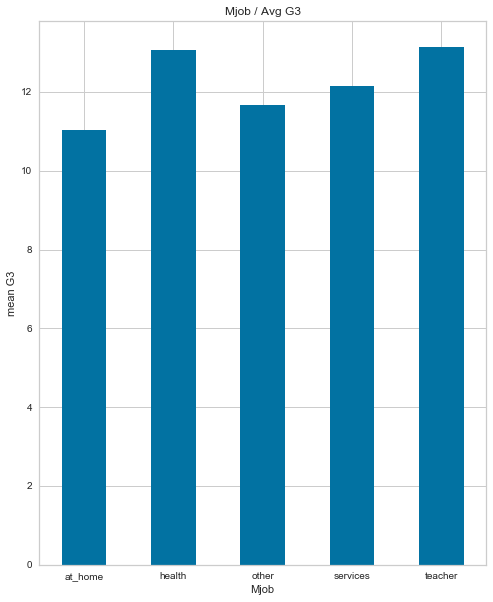

In [724]:
df_new.groupby('Mjob')['G3'].mean().plot.bar(rot=0, ylabel='mean G3', title='Mjob / Avg G3');

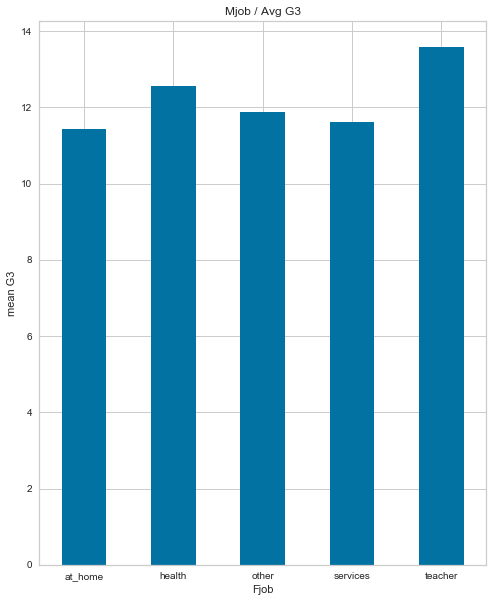

In [725]:
df_new.groupby('Fjob')['G3'].mean().plot.bar(rot=0, ylabel='mean G3', title='Mjob / Avg G3');

### TSLS

In [726]:
from linearmodels.iv import IV2SLS

fmla = 'G3 ~ age + sex + [failures ~ higher + Pedu]'
ols = IV2SLS.from_formula(fmla, data=train_df).fit()
print(f'R^2 = {ols.rsquared}')

R^2 = 0.8848017245694744


In [727]:
# print(ols.predict.__doc__)
mse(ols.predict(),y_train)

17.321933275539

### Lasso, Ridge

In [728]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [769]:
df = init_df_mat.copy(deep=True)

df = prep(df)

pred_cols = [i for i in df.columns if i not in ['G1', 'G2', 'G3']]
y = df['G3']
X = df[pred_cols]

# train/test
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1)

train_df = x_train.join(y_train)
test_df = x_test.join(y_test)

In [763]:
reg = LassoCV()
reg.fit(x_train, y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" % reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.095760
Best score using built-in LassoCV: 0.231015


Text(0.5, 1.0, 'Feature importance using Lasso Model')

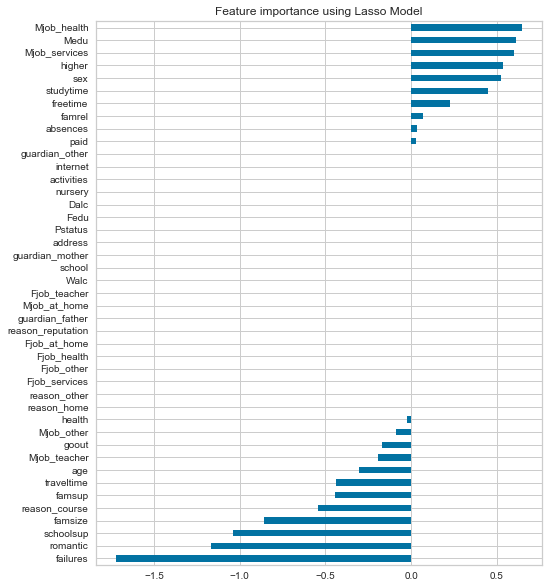

In [764]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [765]:
y_pred = reg.predict(x_test)
mse(y_pred, y_test)

17.08938618096253

In [761]:
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X)

ms = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    
    y_pred = reg.predict(X_test)
    ms += mse(y_pred, y_test) / 10
    
print(ms)

21.58050642966703


In [759]:
reg.score()

AttributeError: 'LassoCV' object has no attribute 'summary'

In [770]:
Ridge
mod = Ridge()
mod.fit(x_train, y_train)


ms = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    
    y_pred = mod.predict(X_test)
    ms += mse(y_pred, y_test) / 10
    
print(ms)

16.20135125877559


### Trees

In [819]:
df = init_df_por.copy(deep=True)

df = prep(df)

pred_cols = [i for i in df.columns if i not in ['G1', 'G2', 'G3']]
y = df['G3']
X = df[pred_cols]

# train/test
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1)

train_df = x_train.join(y_train)
test_df = x_test.join(y_test)

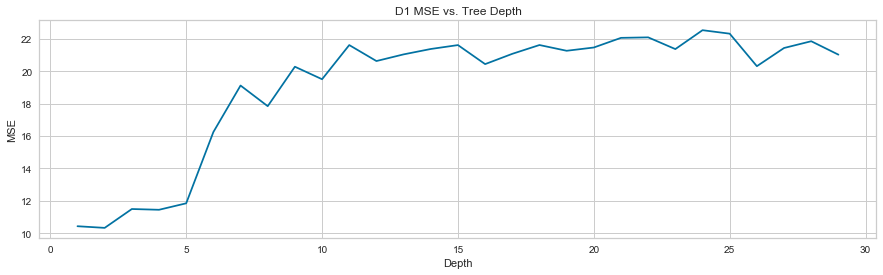

In [820]:
from sklearn.tree import DecisionTreeRegressor

mses = []

for n in range(1, 30):
    mod = DecisionTreeRegressor(max_depth=n)
    mod.fit(x_train, y_train)

    y_pred = mod.predict(x_test)

    mses.append(mse(y_pred, y_test))

plt.figure(figsize=(15, 4))
plt.title('D1 MSE vs. Tree Depth')
plt.xlabel('Depth')
plt.ylabel('MSE')
plt.plot(range(1, 30), mses)

### Forest

In [827]:
df = init_df_mat.copy(deep=True)

df = prep(df)

pred_cols = [i for i in df.columns if i not in ['G1', 'G2', 'G3']]
y = df['G3']
X = df[pred_cols]

# train/test
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1)

train_df = x_train.join(y_train)
test_df = x_test.join(y_test)

In [828]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(x_train, y_train)

RandomForestRegressor(max_depth=2, random_state=0)

In [829]:
y_pred = regr.predict(x_test)
mse(y_pred, y_test)

13.632392426136112

# Part 3. Classification 

In [915]:
# init_df = pd.read_csv('bank.csv', sep=';')
# df = pd.read_csv('bank.csv', sep=';')

# df.replace(['unknown'], np.nan, inplace=True)
# df.dropna(inplace=True)

# binary = ['default', 'housing', 'loan', 'y']

# for c in binary:
#     df[c] = np.where(df[c] == 'yes', 1, 0)
    
# df['marital'] = np.where(df['marital'] == 'married', 1, 0)
# df['contact'] = np.where(df['contact'] == 'cellular', 1, 0)

# g1 = ['unemployed', 'student', 'retired']
# g2 = ['services', 'blue-collar', 'technician', 'housemaid']
# g3 = ['management', 'admin.']
# g4 = ['self-employed', 'entrepreneur']

# job_groups = [g1, g2, g3, g4]
# i = 1
# for g in job_groups:
#     df[f'jg{i}'] = df['job'].isin(g).astype(int)
#     i += 1
    

# df['education'] = np.where(df['education'] == 'primary', 1, df['education'])
# df['education'] = np.where(df['education'] == 'secondary', 2, df['education'])
# df['education'] = np.where(df['education'] == 'tertiary', 3, df['education'])


# df['poutcome'] = np.where(df['poutcome'] == 'success', 1, 0)
     
    
# df.head()

In [916]:
init_df = pd.read_csv('bank.csv', sep=';')
init_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


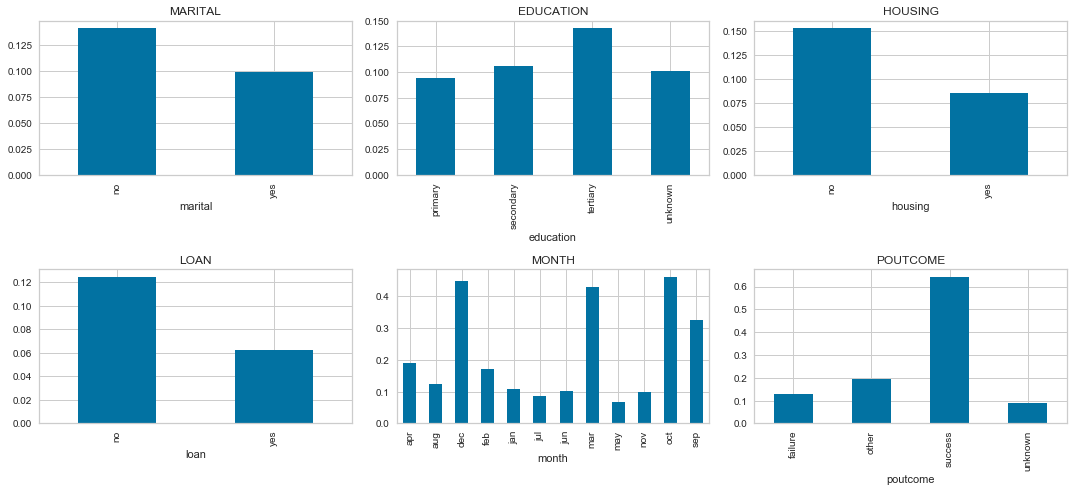

In [1010]:
init_df = pd.read_csv('bank.csv', sep=';')

to_group = ['marital', 'education', 'housing', 'loan', 'month', 'poutcome']

init_df['y'] = np.where(init_df['y'] == 'yes', 1, 0)
init_df['marital'] = np.where(init_df['marital'] == 'married', 'yes', 'no')

# plt.figure(figsize=(10, 5))

fig, axs = plt.subplots(2, 3, figsize=(15, 7))

i = 0
for col in to_group:
    axs[i//3, i%3].set(title=col.upper())
    init_df.groupby(col)['y'].mean().plot.bar(ax=axs[i//3, i%3])
    i += 1
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Month')

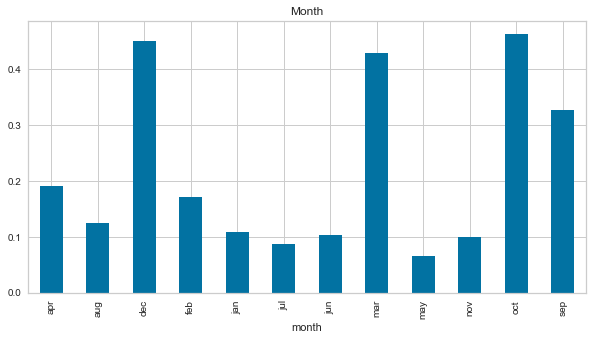

In [1011]:
plt.figure(figsize=(10, 5))

init_df.groupby('month')['y'].mean().plot.bar()
plt.title('Month')

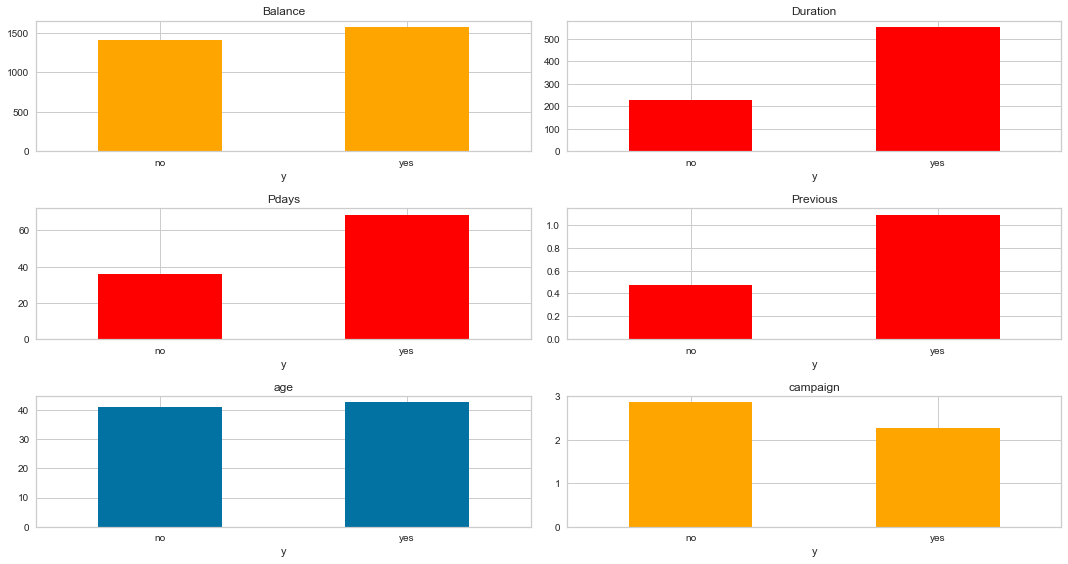

In [901]:
# plt.figure(figsize=(8, 4))
fig, axs = plt.subplots(3, 2, figsize=(15, 8))

axs[0, 0].set(title='Balance')
axs[0, 1].set(title='Duration')
axs[1, 0].set(title='Pdays')
axs[1, 1].set(title='Previous')
axs[2, 0].set(title='age')
axs[2, 1].set(title='campaign')

init_df.groupby('y')['balance'].mean().plot.bar(rot=0, ax = axs[0, 0], color='orange');
init_df.groupby('y')['duration'].mean().plot.bar(rot=0, ax = axs[0, 1], color='red');
init_df.groupby('y')['pdays'].mean().plot.bar(rot=0, ax = axs[1, 0], color='red');
init_df.groupby('y')['previous'].mean().plot.bar(rot=0, ax = axs[1, 1], color='red');
init_df.groupby('y')['age'].mean().plot.bar(rot=0, ax = axs[2, 0]);
init_df.groupby('y')['campaign'].mean().plot.bar(rot=0,  ax = axs[2, 1], color='orange');

plt.tight_layout()

In [1046]:
df = init_df[['y', 'duration', 'pdays', 'previous']].copy(deep=True)

df['poutcome'] = np.where(init_df['poutcome'] == 'success', 1, 0)
df['good_month'] = np.where(init_df['month'].isin(['dec', 'mar', 'oct', 'sep']), 1, 0)
df['housing'] = np.where(init_df['housing'] == 'yes', 1, 0)
df['loan'] = np.where(init_df['loan'] == 'yes', 1, 0)
df['marital'] = np.where(init_df['marital'] == 'married', 1, 0)
df['tedu'] = np.where(init_df['education'] == 'tertiary', 1, 0)
df['retstud'] = np.where(init_df['job'].isin(['retired', 'student']), 1, 0)

df.head()

,y,duration,pdays,previous,poutcome,good_month,housing,loan,marital,tedu,retstud
0,0,79,-1,0,0,1,0,0,0,0,0
1,0,220,339,4,0,0,1,1,0,0,0
2,0,185,330,1,0,0,1,0,0,1,0
3,0,199,-1,0,0,0,1,1,0,1,0
4,0,226,-1,0,0,0,1,0,0,0,0


In [997]:
np.unique(df['y'], return_counts=True)

(array([0, 1]), array([4000,  521]))

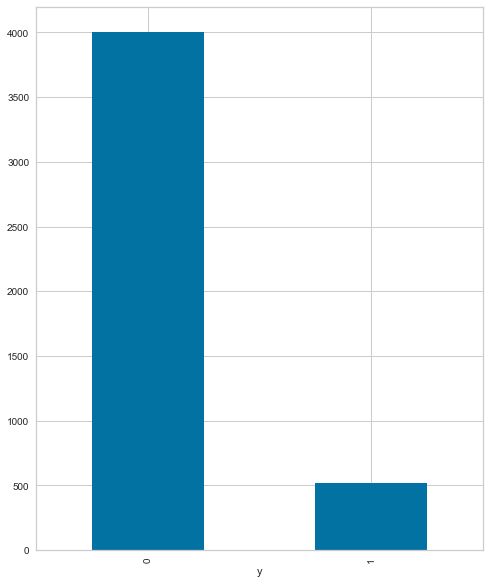

In [1016]:
df.groupby('y')['y'].count().plot.bar()

In [995]:
df.corr().style.background_gradient(cmap='coolwarm').format('{0:,.1f}')

/opt/anaconda3/lib/python3.7/site-packages/pandas/io/formats/style.py:1264: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/opt/anaconda3/lib/python3.7/site-packages/pandas/io/formats/style.py:1265: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,y,duration,pdays,previous,poutcome,good_month,housing,loan,marital,tedu,retstud
y,1.0,0.4,0.1,0.1,0.3,0.2,-0.1,-0.1,nan,0.1,0.1
duration,0.4,1.0,0.0,0.0,0.0,-0.0,0.0,-0.0,nan,-0.0,0.0
pdays,0.1,0.0,1.0,0.6,0.2,0.1,0.1,-0.0,nan,0.0,-0.0
previous,0.1,0.0,0.6,1.0,0.3,0.1,0.0,-0.0,nan,0.0,0.0
poutcome,0.3,0.0,0.2,0.3,1.0,0.2,-0.1,-0.1,nan,0.0,0.0
good_month,0.2,-0.0,0.1,0.1,0.2,1.0,-0.1,-0.1,nan,0.0,0.1
housing,-0.1,0.0,0.1,0.0,-0.1,-0.1,1.0,0.0,nan,-0.1,-0.2
loan,-0.1,-0.0,-0.0,-0.0,-0.1,-0.1,0.0,1.0,nan,-0.0,-0.0
marital,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
tedu,0.1,-0.0,0.0,0.0,0.0,0.0,-0.1,-0.0,nan,1.0,-0.1


ROC:  0.7658725368900692
F1:  0.3804878048780488


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


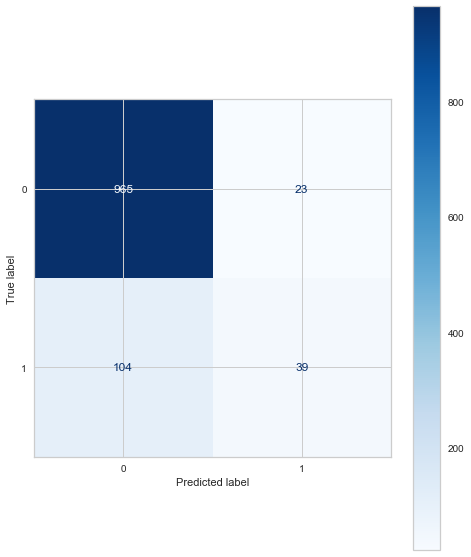

In [1047]:
pred_cols = [i for i in df.columns if i != 'y']
y = df['y']
X = df[pred_cols]

# train/test
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1)


train_df = x_train.join(y_train)
test_df = x_test.join(y_test)

mod = LogisticRegression().fit(x_train, y_train)
plot_confusion_matrix(mod, x_test, y_test, cmap=plt.cm.Blues); 

y_pred = mod.predict(x_test)
print('ROC: ', roc_auc_score(y_pred, y_test))
print('F1: ', f1_score(y_test, y_pred, zero_division=1))

ROC:  0.6810328551745193
F1:  0.6098654708520179
Acc:  0.6660268714011516


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


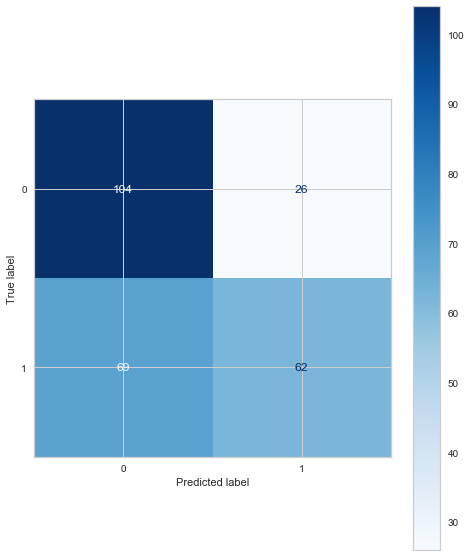

In [1051]:
# undersampling
df = init_df[['y', 'pdays', 'previous']].copy(deep=True)

df['poutcome'] = np.where(init_df['poutcome'] == 'success', 1, 0)
df['good_month'] = np.where(init_df['month'].isin(['dec', 'mar', 'oct', 'sep']), 1, 0)
df['housing'] = np.where(init_df['housing'] == 'yes', 1, 0)
df['loan'] = np.where(init_df['loan'] == 'yes', 1, 0)
df['marital'] = np.where(init_df['marital'] == 'married', 1, 0)
df['tedu'] = np.where(init_df['education'] == 'tertiary', 1, 0)
df['retstud'] = np.where(init_df['job'].isin(['retired', 'student']), 1, 0)

pred_cols = [i for i in df.columns if i != 'y']

cl1 = df[df['y'] == 0].sample(n=521)
cl2 = df[df['y'] == 1]

df = cl1.append(cl2)
y = df['y']
X = df[pred_cols]

# train/test
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1)


train_df = x_train.join(y_train)
test_df = x_test.join(y_test)

mod = LogisticRegression().fit(x_train, y_train)
plot_confusion_matrix(mod, x_test, y_test, cmap=plt.cm.Blues); 

y_pred = mod.predict(X)

print('ROC: ', roc_auc_score(y_pred, y))
print('F1: ', f1_score(y, y_pred, zero_division=1))
print('Acc: ', accuracy_score(y_pred, y))

### Trees

In [1043]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

mod = DecisionTreeClassifier()
cross_val_score(mod, x_train, y_train, cv=10)

array([0.75949367, 0.75641026, 0.73076923, 0.73076923, 0.74358974,
       0.71794872, 0.82051282, 0.65384615, 0.69230769, 0.74358974])

In [ ]:
mod

In [1041]:
from catboost import CatBoostClassifier

ModuleNotFoundError: No module named 'catboost'